In [5]:
# For data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For chemistry
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import PandasTools

# For regression analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [10]:
df = PandasTools.LoadSDF("all_pka_data.sdf")

[16:38:28] Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[16:38:28] ERROR: Could not sanitize molecule ending on line 1449941
[16:38:28] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[16:38:28] Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33
[16:38:28] ERROR: Could not sanitize molecule ending on line 1450328
[16:38:28] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 5 16 17 18 24 25 31 33


In [11]:
df.shape

(17034, 97)

,Name,NON_CHIRAL_CANONICAL_SMILES,STANDARD_SMILES,acid-base,group,pka,pka_method,type,has_tautomer,has_duplicate,...,AminoAcid_count,benz_count,Aromatic_count,6ringHet_count,5ringHet_count,ID,ROMol,bpKa1,canonical_tautomer,stereoisomers
0,atoms 8 bonds 8,Fc1ccc(S)cc1,Fc1ccc(S)cc1,acidic,SH,6.35,mean from 2,a1/apparent,0,0,...,0,1,1,0,0,atoms 8 bonds 8,,NaN,NaN,NaN
1,atoms 8 bonds 8,Sc1cccc(Cl)c1,Sc1cccc(Cl)c1,acidic,SH,5.76,mean from 2,a1/apparent,0,0,...,0,1,1,0,0,atoms 8 bonds 8,,NaN,NaN,NaN
2,atoms 8 bonds 8,Sc1ccc(Cl)cc1,Sc1ccc(Cl)cc1,acidic,NaN,5.82,mean from 2,a1/apparent,0,0,...,0,1,1,0,0,atoms 8 bonds 8,,NaN,NaN,NaN
3,atoms 8 bonds 8,Sc1ccc(Br)cc1,Sc1ccc(Br)cc1,acidic,SH,5.8,NaN,a1/apparent,0,0,...,0,1,1,0,0,atoms 8 bonds 8,,NaN,NaN,NaN
4,atoms 8 bonds 8,SCc1ccccc1,SCc1ccccc1,acidic,S-H,9.43,spectrophotometric,a1/apparent,0,0,...,0,1,1,0,0,atoms 8 bonds 8,,NaN,NaN,NaN

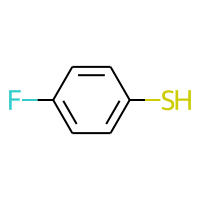
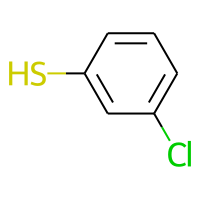
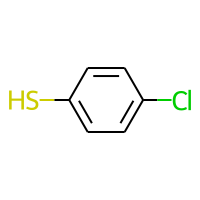
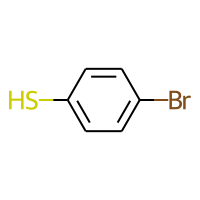
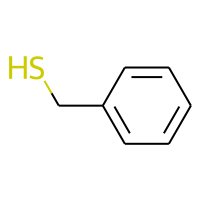

In [12]:
df.head()

In [14]:
df = df[["STANDARD_SMILES", "ROMol"]].copy()

In [20]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

df['fingerprint'] = df.ROMol.apply(lambda x: rdkit_gen.GetFingerprint(x))
fingerprints = df['fingerprint'].to_list()

In [23]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

 With a cutoff of: 0.0, total # clusters:  12058
 With a cutoff of: 0.1, total # clusters:  8765
 With a cutoff of: 0.2, total # clusters:  6091


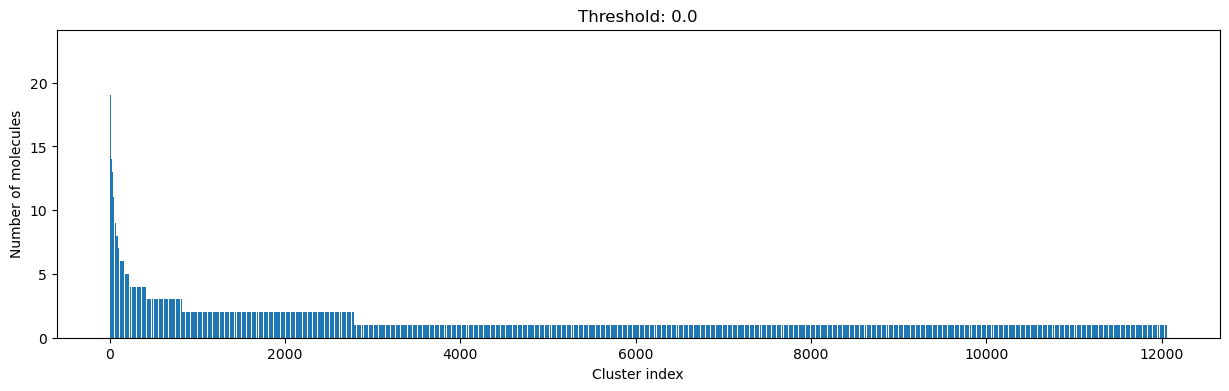

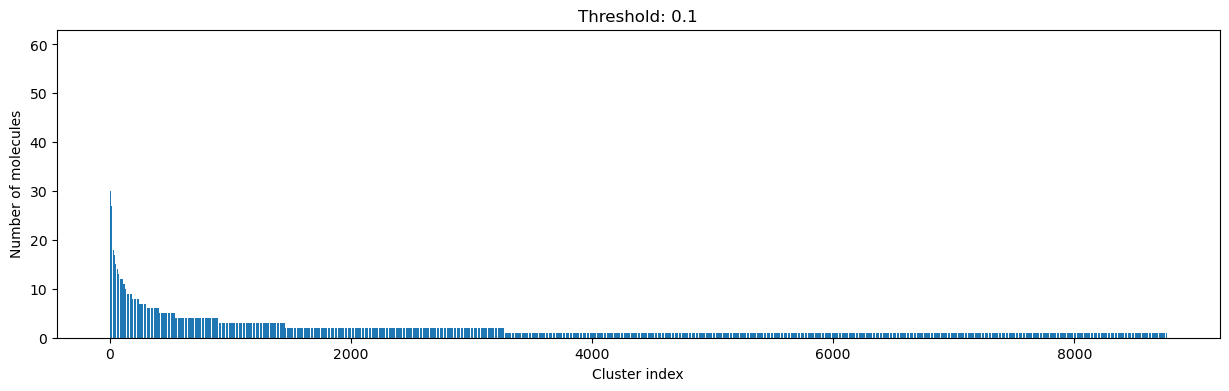

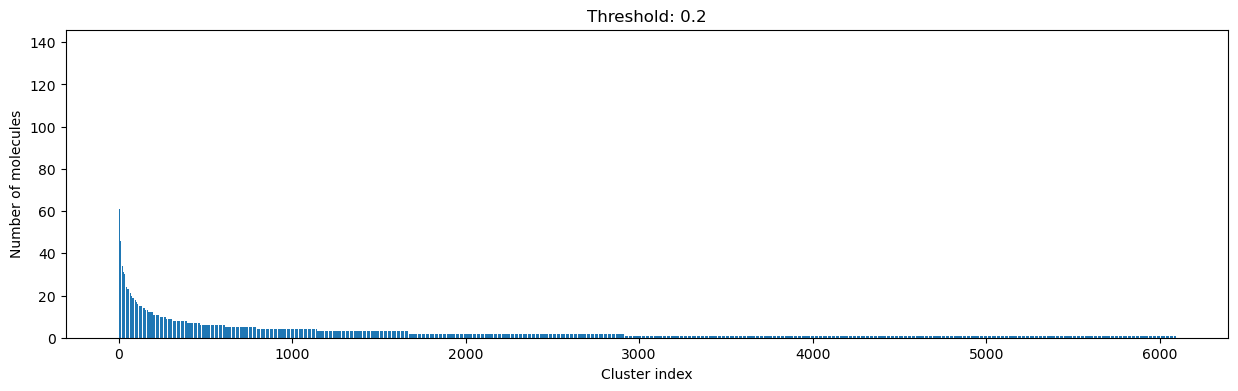

In [25]:
for cutoff in np.arange(0,0.3,0.1):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    print(f" With a cutoff of: {cutoff:.1f}, total # clusters: ", len(clusters))
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)

(15344, 7921, 7938, 7952, 8006, 8029, 8030, 8080, 8231, 8401)
[<rdkit.Chem.rdchem.Mol object at 0x7f820aab3c60>, <rdkit.Chem.rdchem.Mol object at 0x7f8209433e90>, <rdkit.Chem.rdchem.Mol object at 0x7f82094545d0>, <rdkit.Chem.rdchem.Mol object at 0x7f820946d3f0>, <rdkit.Chem.rdchem.Mol object at 0x7f82094cf670>, <rdkit.Chem.rdchem.Mol object at 0x7f82094f72b0>, <rdkit.Chem.rdchem.Mol object at 0x7f82094f7b20>, <rdkit.Chem.rdchem.Mol object at 0x7f82095518a0>, <rdkit.Chem.rdchem.Mol object at 0x7f820965eb20>, <rdkit.Chem.rdchem.Mol object at 0x7f820978f620>]


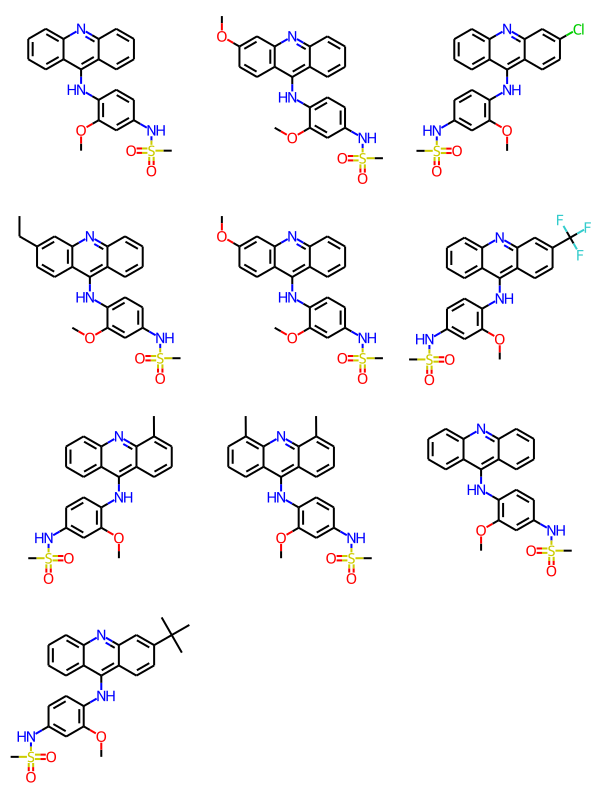

(13687, 7920, 7995, 8013, 8106, 8107, 8120, 8131, 8175, 8183)
[<rdkit.Chem.rdchem.Mol object at 0x7f8209f18e40>, <rdkit.Chem.rdchem.Mol object at 0x7f8209433620>, <rdkit.Chem.rdchem.Mol object at 0x7f82094ba580>, <rdkit.Chem.rdchem.Mol object at 0x7f82094db3f0>, <rdkit.Chem.rdchem.Mol object at 0x7f8209581030>, <rdkit.Chem.rdchem.Mol object at 0x7f82095818a0>, <rdkit.Chem.rdchem.Mol object at 0x7f8209598cb0>, <rdkit.Chem.rdchem.Mol object at 0x7f82095aaf30>, <rdkit.Chem.rdchem.Mol object at 0x7f82095f9a30>, <rdkit.Chem.rdchem.Mol object at 0x7f820960a080>]


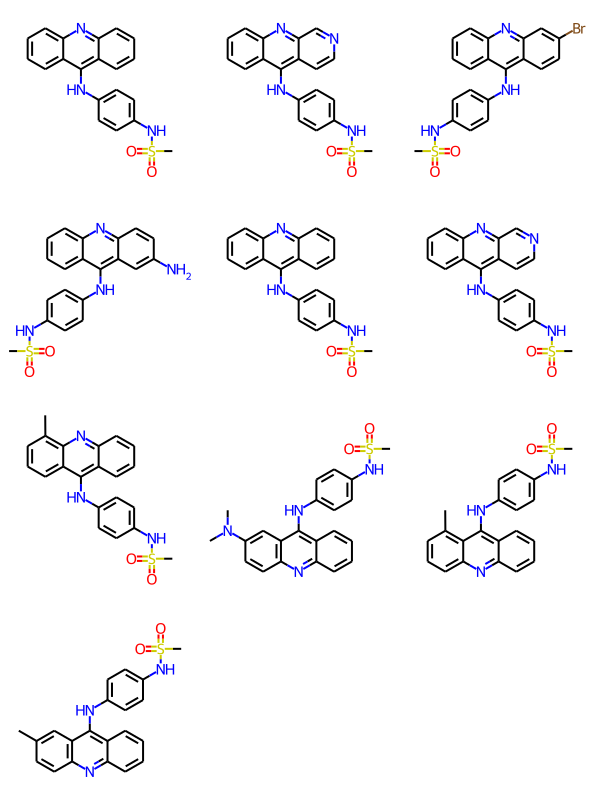

(16684, 4763, 4795, 5893, 5894, 5896, 5897, 6368, 6503, 6507)
[<rdkit.Chem.rdchem.Mol object at 0x7f826c2d0a30>, <rdkit.Chem.rdchem.Mol object at 0x7f82589cb4e0>, <rdkit.Chem.rdchem.Mol object at 0x7f8208dbfda0>, <rdkit.Chem.rdchem.Mol object at 0x7f82092c6300>, <rdkit.Chem.rdchem.Mol object at 0x7f82092c6b70>, <rdkit.Chem.rdchem.Mol object at 0x7f82092c9cb0>, <rdkit.Chem.rdchem.Mol object at 0x7f82092cd580>, <rdkit.Chem.rdchem.Mol object at 0x7f826a3dc350>, <rdkit.Chem.rdchem.Mol object at 0x7f826a4d9cb0>, <rdkit.Chem.rdchem.Mol object at 0x7f826a4e0f30>]


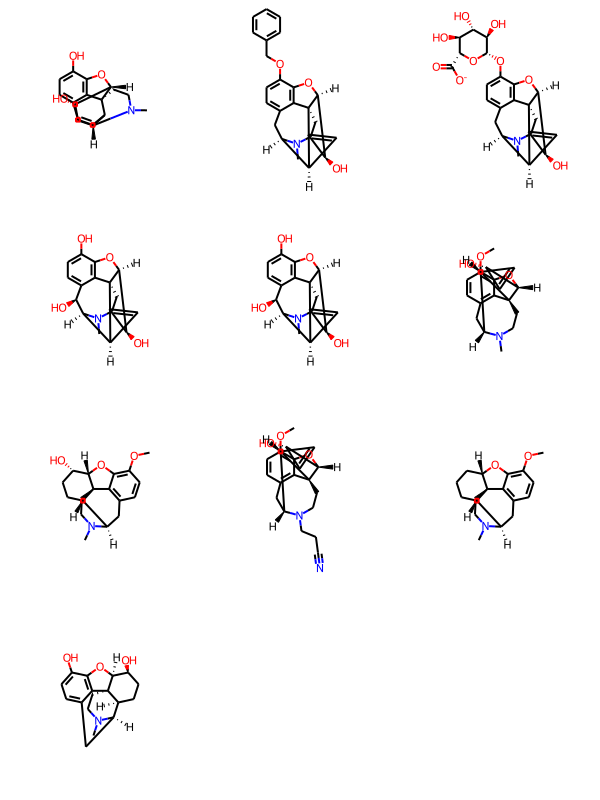

(15010, 5211, 5373, 5374, 5377, 5378, 5779, 5791, 5799, 5890)
[<rdkit.Chem.rdchem.Mol object at 0x7f820a85ecb0>, <rdkit.Chem.rdchem.Mol object at 0x7f8269fa7ad0>, <rdkit.Chem.rdchem.Mol object at 0x7f826a0d7c10>, <rdkit.Chem.rdchem.Mol object at 0x7f826a0da530>, <rdkit.Chem.rdchem.Mol object at 0x7f826a0e1030>, <rdkit.Chem.rdchem.Mol object at 0x7f826a0e18f0>, <rdkit.Chem.rdchem.Mol object at 0x7f82091ef5d0>, <rdkit.Chem.rdchem.Mol object at 0x7f8209206170>, <rdkit.Chem.rdchem.Mol object at 0x7f82092158a0>, <rdkit.Chem.rdchem.Mol object at 0x7f82092bf850>]


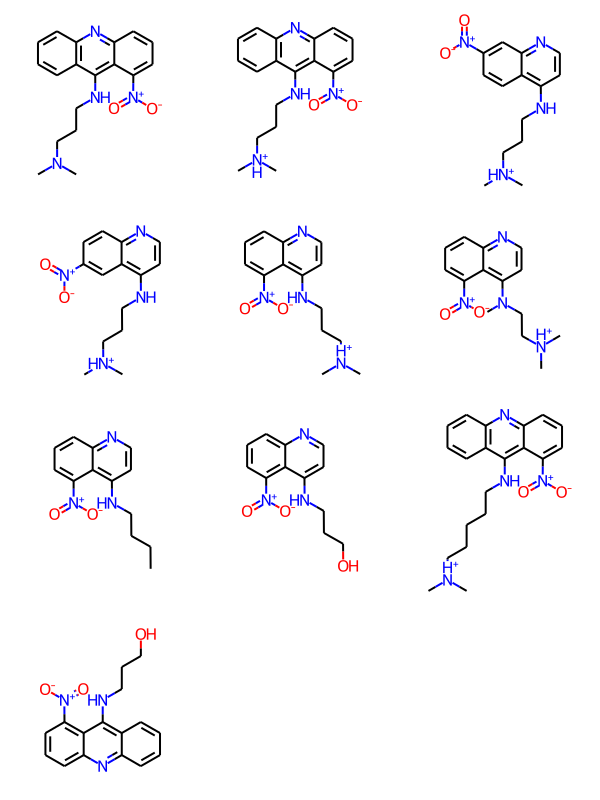

(13074, 8303, 8334, 8363, 8380, 8389, 8403, 8412, 8610, 8675)
[<rdkit.Chem.rdchem.Mol object at 0x7f8209e10210>, <rdkit.Chem.rdchem.Mol object at 0x7f82096df5d0>, <rdkit.Chem.rdchem.Mol object at 0x7f8209717ad0>, <rdkit.Chem.rdchem.Mol object at 0x7f820974ad00>, <rdkit.Chem.rdchem.Mol object at 0x7f82097688a0>, <rdkit.Chem.rdchem.Mol object at 0x7f82097798f0>, <rdkit.Chem.rdchem.Mol object at 0x7f8209791760>, <rdkit.Chem.rdchem.Mol object at 0x7f82097a35d0>, <rdkit.Chem.rdchem.Mol object at 0x7f826ae7e6c0>, <rdkit.Chem.rdchem.Mol object at 0x7f826aef18f0>]


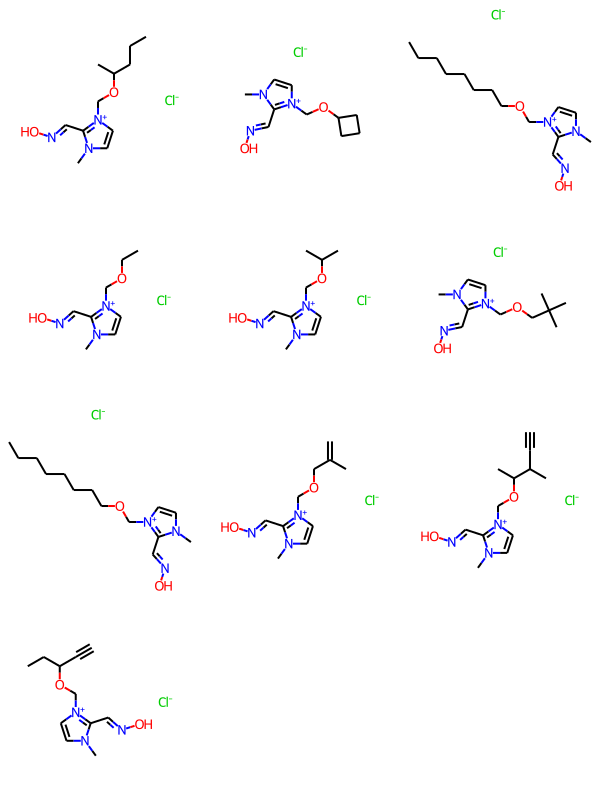

In [53]:
imgs = []
for i in range(0,5):
    cluster = clusters[i]
    top_5_ids = cluster[:10]
    print(top_5_ids)
    top_5_mols = []
    for j in top_5_ids:
        top_5_mols.append(df['ROMol'].to_list()[j])
    print(top_5_mols)
    
    display(Draw.MolsToGridImage(top_5_mols))

In [39]:
clusters[0]

(15344,
 7921,
 7938,
 7952,
 8006,
 8029,
 8030,
 8080,
 8231,
 8401,
 8402,
 8536,
 8537,
 8592,
 8597,
 8647,
 8709,
 8731,
 8739,
 8745,
 8791,
 8806,
 8983,
 8990,
 9047,
 9125,
 9170,
 9176,
 9260,
 9311,
 9414,
 9416,
 9533,
 9537,
 9561,
 9576,
 9581,
 9585,
 9586,
 9610,
 9726,
 9875,
 9990,
 10007,
 10053,
 10057,
 10092,
 10153,
 12489,
 12490,
 12491,
 12492,
 12493,
 12494,
 12495,
 12496,
 12497,
 12498,
 12504,
 12505,
 12506,
 12507,
 12508,
 12509,
 12510,
 12511,
 12512,
 12513,
 12514,
 12515,
 12516,
 12517,
 12522,
 12523,
 12737,
 12871,
 12872,
 12873,
 13140,
 13159,
 13307,
 13309,
 13331,
 13333,
 13369,
 13392,
 13393,
 13467,
 13557,
 13570,
 13625,
 13673,
 13703,
 13709,
 13722,
 13744,
 13788,
 13831,
 13918,
 13924,
 13941,
 13959,
 13986,
 14110,
 14127,
 14178,
 14271,
 14307,
 14319,
 14330,
 14334,
 14517,
 14523,
 14560,
 14566,
 14585,
 14588,
 14612,
 14673,
 14775,
 14779,
 14794,
 14825,
 14834,
 14864,
 14975,
 14990,
 15014,
 15041,
 15142,
 1